In [1]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from collections import defaultdict
from ultralytics import YOLO
from scipy import stats
from tqdm import tqdm
from PIL import Image


C:\Users\gfuen\AppData\Local\Temp\ipykernel_34148\3308140393.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Preprocesamiento

In [2]:
# Metadata para ordenar el entrenamiento
metadata_path = 'datasets\Labeled Stomatal Images.csv'
metadata = pd.read_csv(metadata_path)

In [3]:
#Mediciones 1 plant-out
def onePlantOut(plant_name):
  main_folder = 'datasets'

  train_images_folder = os.path.join(main_folder, 'train/images')
  train_labels_folder = os.path.join(main_folder, 'train/labels')
  val_images_folder = os.path.join(main_folder, 'val/images')
  val_labels_folder = os.path.join(main_folder, 'val/labels')

  folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
  for folder in folders:
      if not os.path.exists(folder):
          os.makedirs(folder)

  # Seleccionar la planta a medir su rendimiento
  plant = plant_name
  trainFiles = metadata[metadata['Species'] != plant]['FileName'].tolist()
  valFiles = metadata[metadata['Species'] == plant]['FileName'].tolist()

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in trainFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in valFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))

def holdOut(random_seed = 42, test_size = 0.2):
    random.seed(random_seed)
    main_folder = 'datasets'

    train_images_folder = os.path.join(main_folder, 'train/images')
    train_labels_folder = os.path.join(main_folder, 'train/labels')
    val_images_folder = os.path.join(main_folder, 'val/images')
    val_labels_folder = os.path.join(main_folder, 'val/labels')

    folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Obtener todos los archivos de la columna 'FileName'
    all_files = metadata['FileName'].tolist()

    # Mezclar aleatoriamente los archivos
    random.shuffle(all_files,)

    split_idx = int((1-test_size) * len(all_files))
    trainFiles = all_files[:split_idx]
    valFiles = all_files[split_idx:]

    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in trainFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))
    
    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in valFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))
                    
def plot_detections(results):
    img_rgb = cv2.cvtColor(results.orig_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    for box, score in zip(results.boxes.xyxy, results.boxes.conf):
        x1, y1, x2, y2 = box
        # Coordenadas deben ser ints
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Mostrar el score como etiqueta en la esquina superior izquierda de la caja
        label = f"{score:.2f}"  # Formatear el score a 2 decimales
        ax.text(x1, y1, label, color='white', fontsize=5, verticalalignment='top', bbox={'color': 'r', 'pad': 0})
        
    plt.show()

def show_image(image_path, txt_path):
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Leer y mostrar el contenido del archivo .txt
    with open(txt_path, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x = (x_center - width / 2) * img.shape[1]
        y = (y_center - height / 2) * img.shape[0]
        w = width * img.shape[1]
        h = height * img.shape[0]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

# Test

In [4]:
# Elegir el tipo de preprocesamiento
holdOut(random_seed = 42, test_size = 0.2)
# onePlantOut("Nuttall oak")

model8 = YOLO('Modelos\yolov8\HoldOutSimpleYolov8n.pt')
model8Adjust = YOLO('Modelos\yolov8\HoldOutAdjustYolov8n.pt')
model10 = YOLO('Modelos\yolov10\HoldOutSimpleYolov10n.pt')
model10Adjust = YOLO('Modelos\yolov10\HoldOutAdjustYolov10n.pt')

## Test visual


image 1/1 c:\Users\gfuen\OneDrive - Universidad Catlica de Chile\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\images\STMHD0007.jpg: 480x640 67 stoma1s, 60 stoma2s, 121.8ms
Speed: 8.0ms preprocess, 121.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


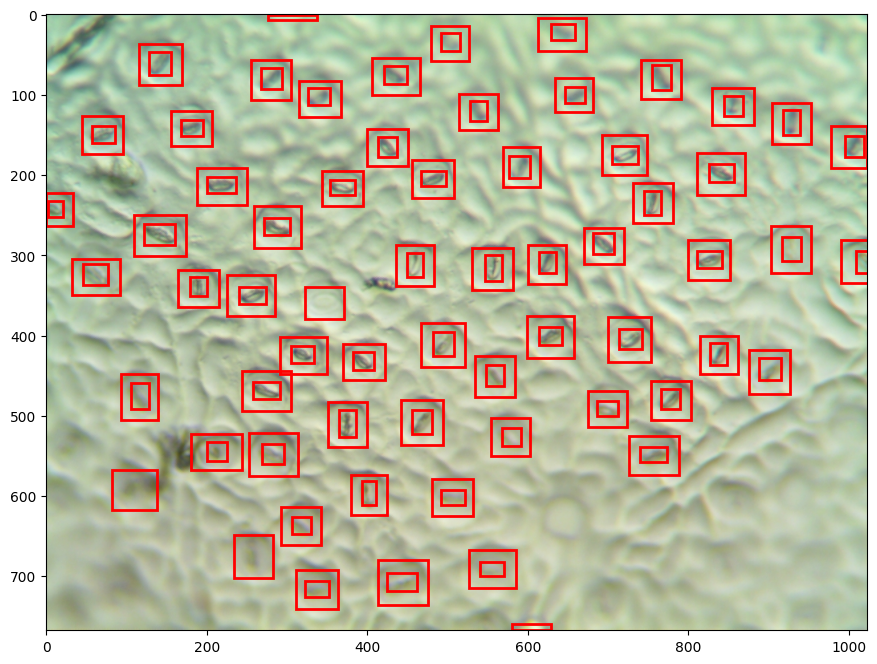

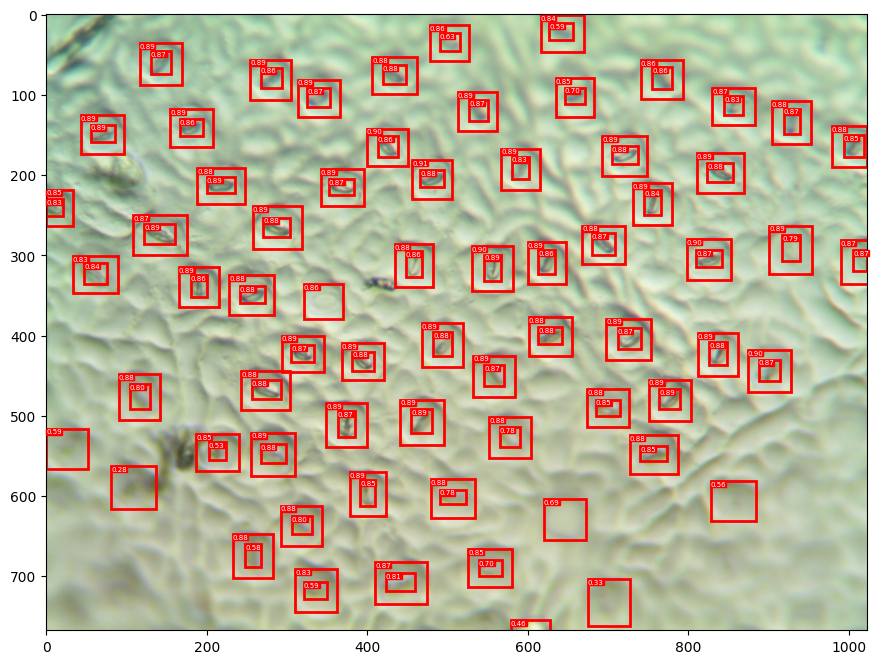

In [5]:
PATH_images = "datasets/val/images"
PATH_labels = "datasets/val/labels"
plant_type = '/STMHD'
number = "0007"
image_path = f"{PATH_images}{plant_type}{number}.jpg"
txt_path = f"{PATH_labels}{plant_type}{number}.txt"

results = model8.predict(image_path)[0]

show_image(image_path, txt_path)
plot_detections(results)

## Test métricas


In [6]:
results8 = model8.val(data='YOLO8INFO.yaml', save_json=False)
results8Adjust = model8Adjust.val(data='YOLO8INFO.yaml', save_json=False)
results10 = model10.val(data='YOLO8INFO.yaml', save_json=False)
results10Adjust = model10Adjust.val(data='YOLO8INFO.yaml', save_json=False)


Ultralytics 8.3.15  Python-3.10.7 torch-2.1.2+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)


100%|██████████| 755k/755k [00:00<00:00, 10.7MB/s]
val: Scanning C:\Users\gfuen\OneDrive - Universidad Católica de Chile\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:10<00:00, 204.49it/s]


val: New cache created: C:\Users\gfuen\OneDrive - Universidad Catlica de Chile\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [10:51<00:00,  4.86s/it]


                   all       2143     163185      0.968      0.964      0.991      0.834
                stoma1       2143      99280      0.973      0.965      0.992      0.853
                stoma2       1807      63905      0.964      0.963       0.99      0.815
Speed: 3.2ms preprocess, 181.1ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\val
Ultralytics 8.3.15  Python-3.10.7 torch-2.1.2+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\gfuen\OneDrive - Universidad Católica de Chile\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [09:11<00:00,  4.11s/it]


                   all       2143     163185      0.969      0.965      0.991      0.819
                stoma1       2143      99280      0.974      0.967      0.992      0.841
                stoma2       1807      63905      0.964      0.964       0.99      0.797
Speed: 2.7ms preprocess, 146.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\val2
Ultralytics 8.3.15  Python-3.10.7 torch-2.1.2+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
YOLOv10n summary (fused): 285 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning C:\Users\gfuen\OneDrive - Universidad Católica de Chile\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [08:19<00:00,  3.73s/it]


                   all       2143     163185      0.967      0.961       0.99      0.835
                stoma1       2143      99280      0.974      0.961      0.992      0.854
                stoma2       1807      63905      0.959      0.961      0.989      0.816
Speed: 1.8ms preprocess, 146.9ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs\detect\val3
Ultralytics 8.3.15  Python-3.10.7 torch-2.1.2+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
YOLOv10n summary (fused): 285 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning C:\Users\gfuen\OneDrive - Universidad Católica de Chile\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [08:21<00:00,  3.74s/it]


                   all       2143     163185      0.962      0.958       0.99      0.822
                stoma1       2143      99280      0.968      0.953       0.99       0.84
                stoma2       1807      63905      0.956      0.962      0.989      0.804
Speed: 1.5ms preprocess, 151.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs\detect\val4


# Contador

In [6]:
def count_bounding_boxes(model, image_path, confidence_threshold):
    results = model.predict(image_path, verbose=False)
    bbox_counts = defaultdict(int)

    for result in results:
        for box in result.boxes: 
            if box.conf >= confidence_threshold:  # Filtrar por el umbral de confianza
                class_id = int(box.cls) 
                bbox_counts[class_id] += 1

    return bbox_counts

def load_labels(label_path):
    labels = defaultdict(list)
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels[class_id].append(bbox)
    return labels

def calculate_differences(pred_counts, real_counts):
    differences = {} 

    all_classes = set(pred_counts.keys()).union(set(real_counts.keys()))

    for class_id in all_classes:
        real_count = real_counts.get(class_id, 0)
        pred_count = pred_counts.get(class_id, 0)

        difference = pred_count - real_count
        differences[class_id] = difference

    return differences

# Confidence Threshold de yolo es 0.25 por defecto
def compare_predictions_with_labels(model, image_path, label_path, confidence_threshold = 0.25): 

    pred_counts = count_bounding_boxes(model, image_path, confidence_threshold)

    real_labels = load_labels(label_path)

    real_counts = {class_id: len(bboxes) for class_id, bboxes in real_labels.items()}

    differences_by_class = calculate_differences(pred_counts, real_counts)

    return differences_by_class


In [8]:
image_dir = 'datasets/val/images'
label_dir = 'datasets/val/labels'

images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

for image_name in images[:1]:
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    differences_by_class = compare_predictions_with_labels(model8, image_path, label_path)
print(differences_by_class)

{0: 3, 1: 1}


In [9]:
image_dir = 'datasets/val/images'
label_dir = 'datasets/val/labels'

images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

differences8 = []
differences8Adjust = []
differences10 = []
differences10Adjust = []

for image_name in tqdm(images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    differences8_by_class = compare_predictions_with_labels(model8, image_path, label_path)
    differences8.append(differences8_by_class)
    differences8Adjust_by_class = compare_predictions_with_labels(model8Adjust, image_path, label_path)
    differences8Adjust.append(differences8Adjust_by_class)
    differences10_by_class = compare_predictions_with_labels(model10, image_path, label_path)
    differences10.append(differences10_by_class)
    differences10Adjust_by_class = compare_predictions_with_labels(model10Adjust, image_path, label_path)
    differences10Adjust.append(differences10Adjust_by_class)


  6%|▌         | 121/2143 [01:11<19:49,  1.70it/s]


KeyboardInterrupt: 

In [10]:
def calculate_statistics(differences):
    media = np.mean(differences)
    mediana = np.median(differences)
    desviacion_estandar = np.std(differences)
    varianza = np.var(differences)
    rango = np.ptp(differences)
    minimo = np.min(differences)
    maximo = np.max(differences)
    sesgo = stats.skew(differences)
    curtosis = stats.kurtosis(differences)
    
    return {
        "media": media,
        "mediana": mediana,
        "desviacion_estandar": desviacion_estandar,
        "varianza": varianza,
        "rango": rango,
        "minimo": minimo,
        "maximo": maximo,
        "sesgo": sesgo,
        "curtosis": curtosis
    }
def flatten_differences_by_class(differences):
    class_differences = defaultdict(list)
    for diff in differences:
        for class_id, value in diff.items():
            class_differences[class_id].append(value)
    return class_differences

def calculate_and_print_stats_by_class(flat_differences):
    for class_id, diffs in flat_differences.items():
        stats_by_class = calculate_statistics(diffs)
        print(f"Clase {class_id}:")
        print(stats_by_class)
        print()


In [74]:
flat_differences8 = flatten_differences_by_class(differences8)
flat_differences8Adjust = flatten_differences_by_class(differences8Adjust)
flat_differences10 = flatten_differences_by_class(differences10)
flat_differences10Adjust = flatten_differences_by_class(differences10Adjust)

print("Métricas estadísticas por clase para model8:")
calculate_and_print_stats_by_class(flat_differences8)

print("Métricas estadísticas por clase para model8Adjust:")
calculate_and_print_stats_by_class(flat_differences8Adjust)

print("Métricas estadísticas por clase para model10:")
calculate_and_print_stats_by_class(flat_differences10)

print("Métricas estadísticas por clase para model10Adjust:")
calculate_and_print_stats_by_class(flat_differences10Adjust)

Métricas estadísticas por clase para model8:
Clase 0:
{'media': 0.9295380307979468, 'mediana': 0.0, 'desviacion_estandar': 2.8153933444413473, 'varianza': 7.9264396839246345, 'rango': 43, 'minimo': -7, 'maximo': 36, 'sesgo': 3.7764537653466914, 'curtosis': 30.326678728388075}

Clase 1:
{'media': 1.698174006444683, 'mediana': 1.0, 'desviacion_estandar': 3.366318750342194, 'varianza': 11.33210192890543, 'rango': 37, 'minimo': -5, 'maximo': 32, 'sesgo': 2.5721472544961874, 'curtosis': 10.981376045668727}

Métricas estadísticas por clase para model8Adjust:
Clase 0:
{'media': 1.0718618758749416, 'mediana': 1.0, 'desviacion_estandar': 2.686352128941726, 'varianza': 7.216487760669743, 'rango': 41, 'minimo': -7, 'maximo': 34, 'sesgo': 3.2584814136647653, 'curtosis': 23.79499662415966}

Clase 1:
{'media': 1.5293484114162628, 'mediana': 1.0, 'desviacion_estandar': 3.2022685240880415, 'varianza': 10.254523700365004, 'rango': 39, 'minimo': -5, 'maximo': 34, 'sesgo': 2.8953081161416456, 'curtosis':

# Contador con threshold

In [11]:
confidence_threshold = 0.5

image_dir = 'datasets/val/images'
label_dir = 'datasets/val/labels'

images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

differences8 = []
differences8Adjust = []
differences10 = []
differences10Adjust = []

for image_name in tqdm(images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    differences8_by_class = compare_predictions_with_labels(model8, image_path, label_path, confidence_threshold)
    differences8.append(differences8_by_class)
    differences8Adjust_by_class = compare_predictions_with_labels(model8Adjust, image_path, label_path, confidence_threshold)
    differences8Adjust.append(differences8Adjust_by_class)
    differences10_by_class = compare_predictions_with_labels(model10, image_path, label_path, confidence_threshold)
    differences10.append(differences10_by_class)
    differences10Adjust_by_class = compare_predictions_with_labels(model10Adjust, image_path, label_path, confidence_threshold)
    differences10Adjust.append(differences10Adjust_by_class)

  5%|▍         | 103/2143 [01:40<33:08,  1.03it/s] 


KeyboardInterrupt: 

In [ ]:
flat_differences8 = flatten_differences_by_class(differences8)
flat_differences8Adjust = flatten_differences_by_class(differences8Adjust)
flat_differences10 = flatten_differences_by_class(differences10)
flat_differences10Adjust = flatten_differences_by_class(differences10Adjust)

print("Métricas estadísticas por clase para model8:")
calculate_and_print_stats_by_class(flat_differences8)

print("Métricas estadísticas por clase para model8Adjust:")
calculate_and_print_stats_by_class(flat_differences8Adjust)

print("Métricas estadísticas por clase para model10:")
calculate_and_print_stats_by_class(flat_differences10)

print("Métricas estadísticas por clase para model10Adjust:")
calculate_and_print_stats_by_class(flat_differences10Adjust)